In [ ]:
!wget https://snap.stanford.edu/data/git_web_ml.zip
!unzip git_web_ml.zip

--2024-06-16 16:11:44--  https://snap.stanford.edu/data/git_web_ml.zip
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396031 (2.3M) [application/zip]
Saving to: ‘git_web_ml.zip’

git_web_ml.zip      100%[===================>]   2.28M  8.68MB/s    in 0.3s    

2024-06-16 16:11:44 (8.68 MB/s) - ‘git_web_ml.zip’ saved [2396031/2396031]

Archive:  git_web_ml.zip
   creating: git_web_ml/
  inflating: git_web_ml/musae_git_edges.csv  
  inflating: git_web_ml/musae_git_features.json  
  inflating: git_web_ml/musae_git_target.csv  
  inflating: git_web_ml/citing.txt   
  inflating: git_web_ml/README.txt   


In [ ]:
import pandas as pd

edges = pd.read_csv('/content/git_web_ml/musae_git_edges.csv')
print("Edges preview:")
print(edges.head())

targets = pd.read_csv('/content/git_web_ml/musae_git_target.csv')
print("\nTargets preview:")
print(targets.head())


Edges preview:
   id_1   id_2
0     0  23977
1     1  34526
2     1   2370
3     1  14683
4     1  29982

Targets preview:
   id          name  ml_target
0   0        Eiryyy          0
1   1    shawflying          0
2   2   JpMCarrilho          1
3   3     SuhwanCha          0
4   4  sunilangadi2          1


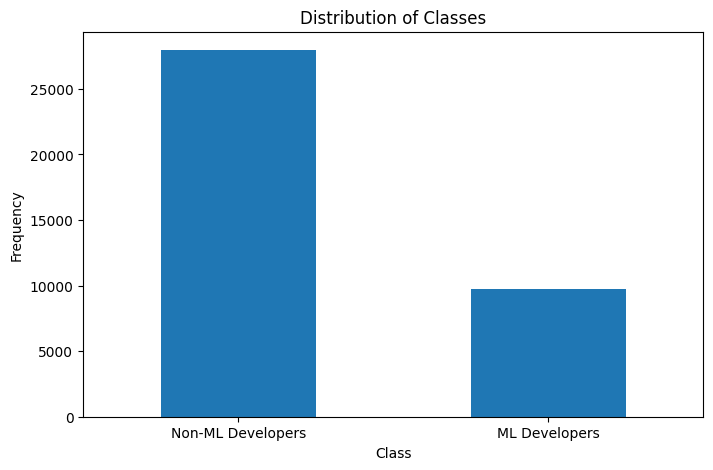

In [ ]:
import matplotlib.pyplot as plt

class_distribution = targets['ml_target'].value_counts()

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Non-ML Developers', 'ML Developers'], rotation=0)
plt.show()


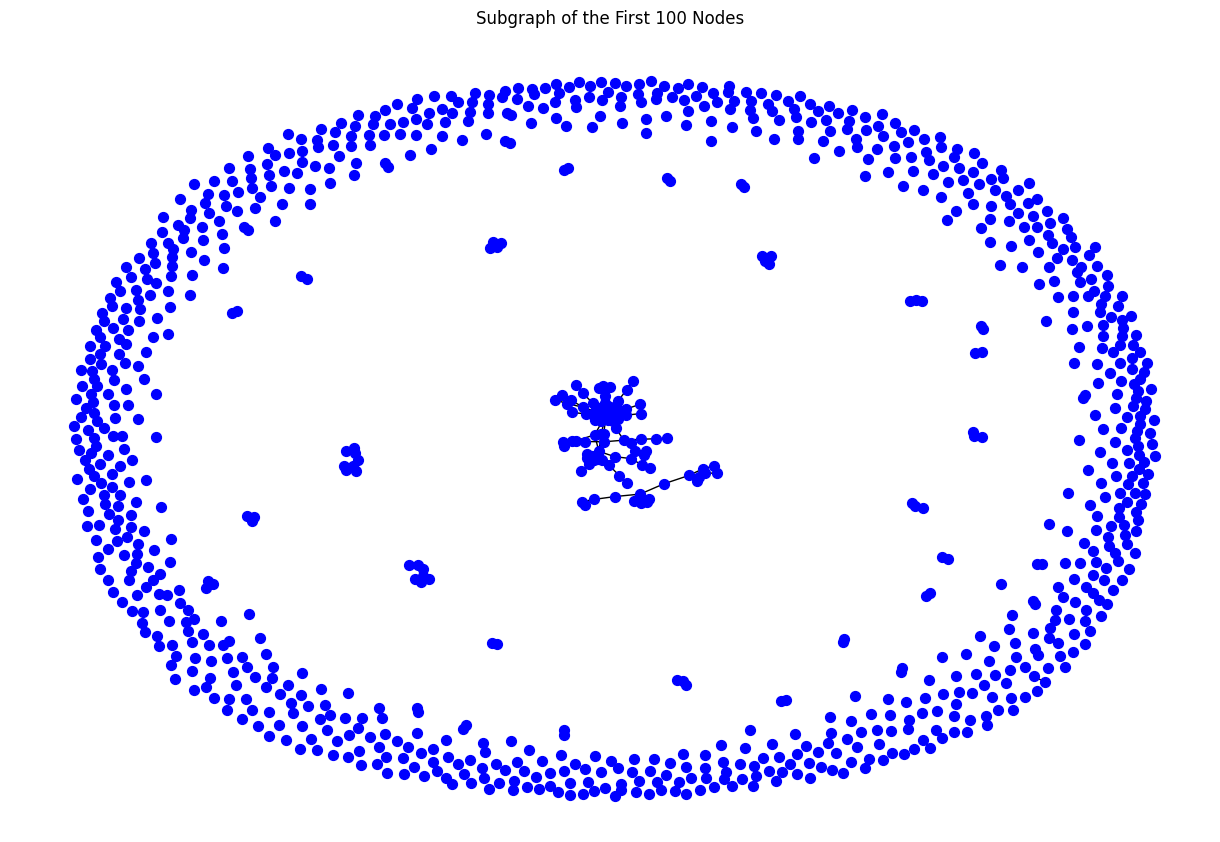

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(edges, 'id_1', 'id_2')

small_subgraph = nx.subgraph(G, list(range(1000)))
plt.figure(figsize=(12, 8))
nx.draw(small_subgraph, node_size=50, node_color='blue', with_labels=False)
plt.title('Subgraph of the First 1000 Nodes')
plt.show()


In [ ]:

!pip install torch torchvision
!pip install torch-geometric
!pip install torch-sparse torch-scatter torch-cluster


  Using cached torch_geometric-2.5.3-py3-none-any.whl (1.1 MB)
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 417, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 320, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packa

In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor(edges.values, dtype=torch.long).t().contiguous()
x = torch.eye(targets['id'].max() + 1)
y = torch.tensor(targets['ml_target'].values, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

In [ ]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(range(data.num_nodes), test_size=0.2, stratify=data.y.numpy(), random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, stratify=data.y[train_idx].numpy(), random_state=42)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True


In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(num_features=data.num_node_features, num_classes=torch.max(data.y).item() + 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
import matplotlib.pyplot as plt

def train(model, data, train_mask, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        accuracy = int(correct.sum()) / int(mask.sum())
        loss = F.nll_loss(out[mask], data.y[mask]).item()
    return accuracy, loss

train_losses = []
val_losses = []
val_accuracies = []

epochs = 30
for epoch in range(epochs):
    train_loss = train(model, data, data.train_mask, optimizer)
    val_accuracy, val_loss = evaluate(model, data, data.val_mask)

    # Store the metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/30, Train Loss: 0.6933, Val Loss: 0.6727, Val Accuracy: 0.7416
Epoch 6/30, Train Loss: 0.5851, Val Loss: 0.5712, Val Accuracy: 0.7422
Epoch 11/30, Train Loss: 0.4829, Val Loss: 0.4922, Val Accuracy: 0.7566
Epoch 16/30, Train Loss: 0.4038, Val Loss: 0.4437, Val Accuracy: 0.7976
Epoch 21/30, Train Loss: 0.3385, Val Loss: 0.4118, Val Accuracy: 0.8231
Epoch 26/30, Train Loss: 0.2838, Val Loss: 0.3972, Val Accuracy: 0.8337


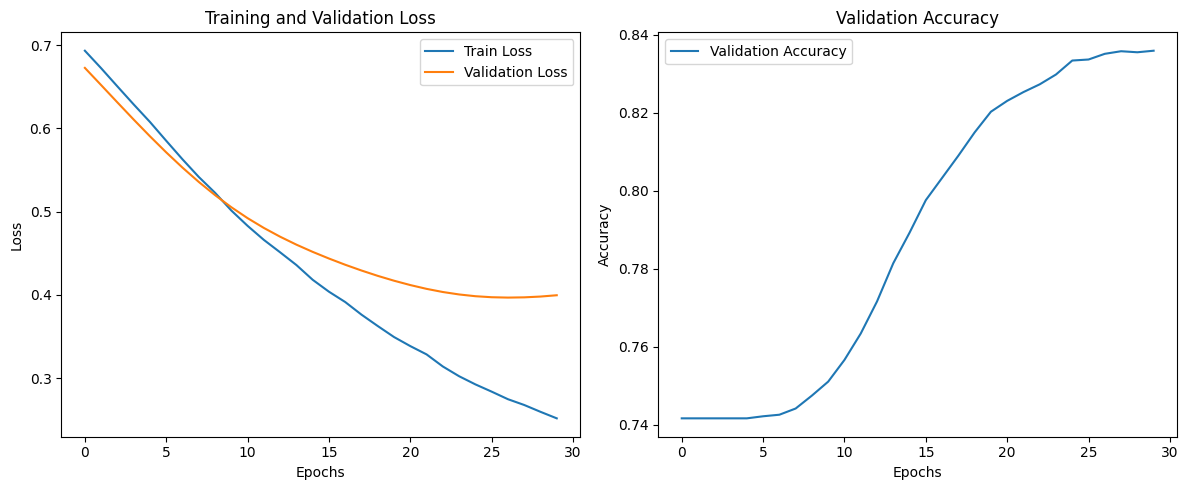

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        accuracy = int(correct.sum()) / int(mask.sum())
        loss = F.nll_loss(out[mask], data.y[mask]).item()
    return accuracy, loss

test_accuracy, test_loss = evaluate(model, data, data.test_mask)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.4192, Test Accuracy: 0.8284
